In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
from exp.nb_06 import *

## ConvNet

In [ ]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [ ]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [ ]:
nfs = [8,16,32,32]

In [ ]:
learn,run = get_learn_run(nfs, data, 0.8, conv_layer, cbs=cbfs)

In [ ]:
%time run.fit(1, learn)

train: [1.63907625, tensor(0.4483, device='cuda:0')]
valid: [0.56672900390625, tensor(0.8311, device='cuda:0')]
CPU times: user 2.33 s, sys: 888 ms, total: 3.21 s
Wall time: 3.21 s


## Batchnorm

### Custom

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.zeros(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        self.steps = 0

    def update_stats(self, x):
        self.steps += 1
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.detach_()
        self.vars.detach_()
        mom = 1. if self.steps==1 else self.mom
        self.means.lerp_(m, mom)
        self.vars.lerp_ (v, mom)
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        x = (x-self.means).div_((self.vars+self.eps).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [ ]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.4244470703125, tensor(0.8775, device='cuda:0')]
valid: [0.168459765625, tensor(0.9556, device='cuda:0')]


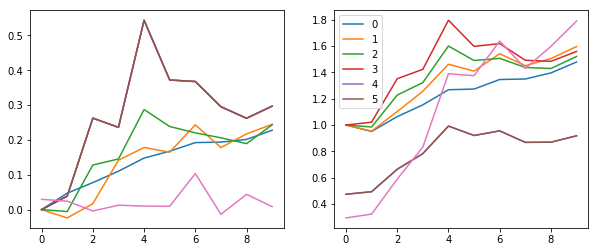

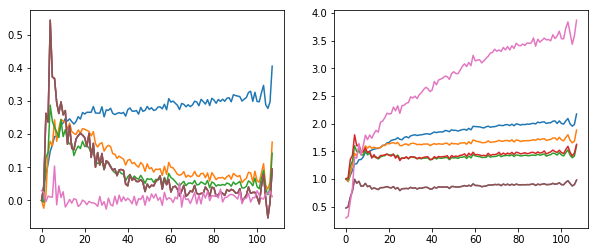

In [ ]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [ ]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [0.4624445703125, tensor(0.8601, device='cuda:0')]
valid: [0.1636791015625, tensor(0.9560, device='cuda:0')]
train: [0.147957431640625, tensor(0.9565, device='cuda:0')]
valid: [0.11624248046875, tensor(0.9665, device='cuda:0')]
train: [0.111165283203125, tensor(0.9668, device='cuda:0')]
valid: [0.092507275390625, tensor(0.9730, device='cuda:0')]
CPU times: user 3.52 s, sys: 476 ms, total: 4 s
Wall time: 4 s


### Bias corrected

See XL file *mom_bias.xlsx*.

In [ ]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.zeros(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        self.steps = 0

    def update_stats(self, x):
        self.steps += 1
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.detach_()
        self.vars.detach_()
        mom = self.mom
        self.means.lerp_(m, mom)
        self.vars.lerp_ (v, mom)
        
    def forward(self, x):
        if self.training: self.update_stats(x)
        means = self.means
        vars  = self.vars
        if self.steps<100:
            corr = 1-(1-self.mom)**self.steps
            means = means/corr
            vars  = vars /corr
        x = (x-means).div_((vars+self.eps).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.8, conv_layer, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [0.416889140625, tensor(0.8799, device='cuda:0')]
valid: [0.608126513671875, tensor(0.8132, device='cuda:0')]
train: [0.152734150390625, tensor(0.9553, device='cuda:0')]
valid: [0.110173779296875, tensor(0.9694, device='cuda:0')]
train: [0.1070734375, tensor(0.9681, device='cuda:0')]
valid: [0.1031563232421875, tensor(0.9700, device='cuda:0')]
CPU times: user 3.55 s, sys: 445 ms, total: 3.99 s
Wall time: 4 s


### jit

In [ ]:
#export
from torch.jit import ScriptModule, script_method, script
from typing import *

class BatchNormJit(ScriptModule):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mults = nn.Parameter(torch.ones (1,nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(1,nf,1,1))
        self.register_buffer('vars',  torch.zeros(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
        self.register_buffer('steps', tensor(0))

    @script_method
    def update_stats(self, x):
        self.steps += 1
        mom,eps = 0.1,1e-5
        m, invstd = torch.batch_norm_stats(x, eps)
        views = (1,-1,1,1)
        m = m.view(*views)
        v = (invstd**-2).view(*views)
        if bool(self.steps>0):
            m = self.means*(1-mom) + m*mom
            v = self.vars *(1-mom) + v*mom
        self.means.copy_(m.detach())
        self.vars .copy_(v.detach())
        
    @script_method
    def forward(self, x):
        if self.training: self.update_stats(x)
        # squeeze.unsqueeze is to create a barrier to trick the fuser
        factor = (self.mults/self.vars.sqrt()).squeeze(-1).unsqueeze(-1)
        offset = (self.adds-self.means).squeeze(-1).unsqueeze(-1)
        return factor * (x+offset)

In [ ]:
def conv_jit(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNormJit(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.8, conv_jit, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [nan, tensor(0.0984, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.47 s, sys: 452 ms, total: 4.92 s
Wall time: 4.92 s


### Builtin batchnorm

In [ ]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.8, conv_layer, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [0.4807440234375, tensor(0.8586, device='cuda:0')]
valid: [0.12600108642578126, tensor(0.9641, device='cuda:0')]
train: [0.104688974609375, tensor(0.9686, device='cuda:0')]
valid: [0.08653324584960938, tensor(0.9739, device='cuda:0')]
train: [0.072819384765625, tensor(0.9781, device='cuda:0')]
valid: [0.1579060791015625, tensor(0.9513, device='cuda:0')]
CPU times: user 2.7 s, sys: 278 ms, total: 2.98 s
Wall time: 2.98 s


### With scheduler

In [ ]:
sched = combine_scheds([0.5, 0.5], [sched_lin(0.2, 1.), sched_lin(1., 0.1)]) 

In [ ]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [ ]:
run.fit(8, learn)

train: [1.04039875, tensor(0.7148, device='cuda:0')]
valid: [0.240669921875, tensor(0.9373, device='cuda:0')]
train: [0.1803751171875, tensor(0.9492, device='cuda:0')]
valid: [0.1454875, tensor(0.9592, device='cuda:0')]
train: [0.104181181640625, tensor(0.9698, device='cuda:0')]
valid: [0.08910442504882812, tensor(0.9743, device='cuda:0')]
train: [0.0783616455078125, tensor(0.9760, device='cuda:0')]
valid: [0.13091724853515624, tensor(0.9612, device='cuda:0')]
train: [0.0602369091796875, tensor(0.9817, device='cuda:0')]
valid: [0.0673140869140625, tensor(0.9793, device='cuda:0')]
train: [0.0450689013671875, tensor(0.9869, device='cuda:0')]
valid: [0.05500914306640625, tensor(0.9841, device='cuda:0')]
train: [0.0345672021484375, tensor(0.9903, device='cuda:0')]
valid: [0.05089189147949219, tensor(0.9841, device='cuda:0')]
train: [0.02767552734375, tensor(0.9925, device='cuda:0')]
valid: [0.04703995971679688, tensor(0.9849, device='cuda:0')]


## More norms

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

In [ ]:
class LayerNorm(ScriptModule):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    @script_method
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.std ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [ ]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [0.484382421875, tensor(0.8470, device='cuda:0')]
valid: [0.1195010498046875, tensor(0.9664, device='cuda:0')]
train: [0.11501509765625, tensor(0.9643, device='cuda:0')]
valid: [0.0873831298828125, tensor(0.9735, device='cuda:0')]
train: [0.069044267578125, tensor(0.9777, device='cuda:0')]
valid: [0.07121566162109375, tensor(0.9785, device='cuda:0')]
CPU times: user 4.19 s, sys: 511 ms, total: 4.7 s
Wall time: 4.7 s


*Thought experiment*: can this distinguish green frogs from red frogs (assuming you're using it before the first conv)?

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

In [ ]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.std ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [ ]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [2.30295890625, tensor(0.1075, device='cuda:0')]
valid: [2.3020640625, tensor(0.1064, device='cuda:0')]
train: [2.30127734375, tensor(0.1136, device='cuda:0')]
valid: [2.301862890625, tensor(0.1064, device='cuda:0')]
train: [2.30114171875, tensor(0.1136, device='cuda:0')]
valid: [2.3020126953125, tensor(0.1064, device='cuda:0')]
CPU times: user 3.64 s, sys: 507 ms, total: 4.15 s
Wall time: 4.15 s


*Question*: why can't this classify anything?

### Group norm

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectorss of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: :math:`(N, num\_channels, *)`
- Output: :math:`(N, num\_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

### Exponentially Weighted Layer Norm

In [ ]:
class EWLayerNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('sum'  , tensor(0.))
        self.register_buffer('sqr'  , tensor(0.))
        self.register_buffer('count', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sum.detach_()
        self.sqr.detach_()
        mom = 1 if self.batch==0 else self.mom
        self.sum  .add_(mom, x.sum()     - self.sum  )
        self.sqr  .add_(mom, (x*x).sum() - self.sqr  )
        self.count.add_(mom, x.numel()   - self.count)
        self.batch += bs

    def forward(self, x):
        if self.training: self.update_stats(x)
        mean = self.sum/self.count
        var  = self.sqr/self.count - mean.pow(2)
        x = (x-mean)/((var+self.eps).sqrt())
        return x*self.mult + self.add

In [ ]:
def conv_ewln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(EWLayerNorm(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.6, conv_ewln, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [0.4745987109375, tensor(0.8501, device='cuda:0')]
valid: [0.15462315673828125, tensor(0.9546, device='cuda:0')]
train: [0.1423449609375, tensor(0.9565, device='cuda:0')]
valid: [0.11461904296875, tensor(0.9652, device='cuda:0')]
train: [0.09990123046875, tensor(0.9691, device='cuda:0')]
valid: [0.083691064453125, tensor(0.9747, device='cuda:0')]
CPU times: user 4.38 s, sys: 591 ms, total: 4.97 s
Wall time: 4.98 s


### Exponentially Weighted Batch Norm

In [ ]:
class EWBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.01, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        self.mom1 = self.dbias.new_tensor(1 - (1-self.mom)**x.shape[0])
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias.lerp_(self.mom1, self.mom1)
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [ ]:
def conv_ewbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(EWBatchNorm(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 4, conv_ewbn, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [0.3655568359375, tensor(0.8842, device='cuda:0')]
valid: [0.1037153564453125, tensor(0.9706, device='cuda:0')]
train: [0.0777454052734375, tensor(0.9763, device='cuda:0')]
valid: [0.0712057861328125, tensor(0.9795, device='cuda:0')]
train: [0.0537394970703125, tensor(0.9834, device='cuda:0')]
valid: [0.06340899658203125, tensor(0.9814, device='cuda:0')]
CPU times: user 4.24 s, sys: 537 ms, total: 4.78 s
Wall time: 4.78 s


In [ ]:
learn,run = get_learn_run(nfs, data, 0.9, conv_ewbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [ ]:
run.fit(8, learn)

train: [0.623816875, tensor(0.8351, device='cuda:0')]
valid: [0.2730313232421875, tensor(0.9192, device='cuda:0')]
train: [0.13766603515625, tensor(0.9612, device='cuda:0')]
valid: [0.14829573974609375, tensor(0.9548, device='cuda:0')]
train: [0.086273017578125, tensor(0.9742, device='cuda:0')]
valid: [0.09565546875, tensor(0.9729, device='cuda:0')]
train: [0.06433189453125, tensor(0.9801, device='cuda:0')]
valid: [0.09912955322265625, tensor(0.9703, device='cuda:0')]
train: [0.046377255859375, tensor(0.9859, device='cuda:0')]
valid: [0.05765380859375, tensor(0.9827, device='cuda:0')]
train: [0.03398404052734375, tensor(0.9900, device='cuda:0')]
valid: [0.05323286743164062, tensor(0.9842, device='cuda:0')]
train: [0.025488779296875, tensor(0.9936, device='cuda:0')]
valid: [0.048959304809570316, tensor(0.9853, device='cuda:0')]
train: [0.02033477294921875, tensor(0.9955, device='cuda:0')]
valid: [0.04754931945800781, tensor(0.9858, device='cuda:0')]


## Export

In [ ]:
!python notebook2script.py 07_batchnorm.ipynb

Converted 07_batchnorm.ipynb to nb_07.py
